In [2]:
import time
import numpy as np
import pandas as pd
import featuretools as ft
import catboost
from tqdm import tqdm_notebook
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.optimize
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score
from sklearn.externals import joblib
from category_encoders import CatBoostEncoder

In [19]:
# Read data
train_raw = pd.read_csv("train_pre_27.csv")
X_test = pd.read_csv("test_pre_27.csv")

# train_raw = pd.read_csv("train_pre_13.csv")
# X_test = pd.read_csv("test_pre_13.csv")

# train_raw = pd.read_csv("train_pre_pure.csv")
# X_test = pd.read_csv("test_pre_pure.csv")

test_raw = pd.read_csv("test.csv")

X = train_raw.drop('fraud_ind', axis=1)
y = train_raw['fraud_ind']

print(train_raw.shape)
print(X_test.shape)
print(test_raw.shape)

(1470838, 113)
(421665, 112)
(421665, 22)


### Cat_boost Encoding

In [16]:
train_raw_X = train_raw.loc[:, ~train_raw.columns.isin(["fraud_ind"])]
train_raw_y = train_raw["fraud_ind"]

# Beware, the training data have to be randomly permutated. E.g.:Random permutation 
perm = np.random.permutation(len(train_raw_X)) 
train_raw_X = train_raw_X.iloc[perm].reset_index(drop=True) 
train_raw_y = train_raw_y.iloc[perm].reset_index(drop=True)

cat_encoder = CatBoostEncoder(cols=["bacno","cano","acqic","mchno","mcc","scity","etymd","stocn","csmcu"])
cat_encoder.fit(train_raw_X, train_raw_y)

CatBoostEncoder(cols=['bacno', 'cano', 'acqic', 'mchno', 'mcc', 'scity', 'etymd', 'stocn', 'csmcu'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value', random_state=None, return_df=True,
        sigma=None, verbose=0)

In [17]:
X = cat_encoder.transform(train_raw_X)
y = train_raw_y
X_test = cat_encoder.transform(X_test)

In [18]:
X

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,stscd_cnt_each_hour,csmcu_cnt_each_hour,mchno_cnt_by_locdt_loctm_hour,acqic_cnt_by_locdt_loctm_hour,conam_cnt_by_locdt_loctm_hour,mcc_cnt_by_locdt_loctm_hour,scity_cnt_by_locdt_loctm_hour,stscd_cnt_by_locdt_loctm_hour,csmcu_cnt_by_locdt_loctm_hour,conam_is_0_cnt_by_bacno
0,0.001377,0.000130,0.000571,513.80,5,0.000894,0,0.001134,0,0,...,15256,2222,9,15,20,15,19,158,18,5
1,0.000603,0.000309,0.000309,570.66,5,0.005664,0,0.000474,0,0,...,116247,101106,1,161,3,113,15,1031,927,0
2,0.000603,0.001904,0.001904,578.38,5,0.005664,0,0.000474,0,0,...,146637,83242,2,65,1,109,3,1241,632,0
3,0.000576,0.000544,0.000761,407.87,5,0.005664,0,0.000502,0,0,...,123316,108303,1,168,8,6,32,1021,861,3
4,0.058553,0.000067,0.000067,103.48,5,0.005664,1,0.018307,0,0,...,16654,9056,16,9,5,16,17,110,75,1
5,0.001485,0.000260,0.000519,704.23,5,0.005664,1,0.018307,0,0,...,125541,108219,1,7,1,7,6,1066,892,1
6,0.000315,0.000761,0.001904,759.87,5,0.005664,0,0.000502,0,0,...,125780,110247,2,110,1,22,542,1087,971,0
7,0.000634,0.000601,0.001269,201.39,5,0.005664,0,0.000502,0,0,...,111829,94792,1,55,2,76,348,820,697,0
8,0.000603,0.002855,0.002855,1046.24,5,0.005664,0,0.000502,0,0,...,124953,108995,2,189,1,143,17,1236,1088,0
9,0.000315,0.001428,0.001428,391.36,5,0.005664,0,0.000502,0,0,...,15256,11350,1,13,1,1,57,139,101,0


In [8]:
X.columns.values.tolist()

['acqic',
 'bacno',
 'cano',
 'conam',
 'contp',
 'csmcu',
 'ecfg',
 'etymd',
 'flbmk',
 'flg_3dsmk',
 'hcefg',
 'insfg',
 'iterm',
 'locdt',
 'mcc',
 'mchno',
 'ovrlt',
 'scity',
 'stocn',
 'stscd',
 'loctm_hour',
 'loctm_min',
 'loctm_sec',
 'conam_is_0',
 'bacno_u_cnt_by_acqic',
 'conam_level',
 'loctm_value_counts',
 'loctm_hour_value_counts',
 'csmcu_cnt_by_stocn',
 'csmcu_cnt_by_scity',
 'csmcu_ucnt_by_bacno',
 'bacno_value_counts',
 'cano_value_counts',
 'mchno_value_counts',
 'acqic_value_counts',
 'mcc_value_counts',
 'ecfg_value_counts',
 'insfg_value_counts',
 'contp_value_counts',
 'etymd_value_counts',
 'stocn_value_counts',
 'scity_value_counts',
 'stscd_value_counts',
 'ovrlt_value_counts',
 'flbmk_value_counts',
 'hcefg_value_counts',
 'csmcu_value_counts',
 'flg_3dsmk_value_counts',
 'prime_time_normal',
 'prime_time_fraud',
 'sleep_time',
 'sleep_time_conam_lower_3000',
 'prime_time_fraud_conam_lower_3000',
 'conam_mean_by_bacno',
 'conam_mean_by_cano',
 'conam_mean_b

In [5]:
all_features = pd.concat([X, X_test], axis=0)
all_features.tail()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,stscd_cnt_each_hour,csmcu_cnt_each_hour,mchno_cnt_by_locdt_loctm_hour,acqic_cnt_by_locdt_loctm_hour,conam_cnt_by_locdt_loctm_hour,mcc_cnt_by_locdt_loctm_hour,scity_cnt_by_locdt_loctm_hour,stscd_cnt_by_locdt_loctm_hour,csmcu_cnt_by_locdt_loctm_hour,conam_is_0_cnt_by_bacno
421660,0.000315,0.011421,0.011421,633.76,5,0.005664,0,0.018307,0,0,...,107875,93247,63,98,2,97,535,907,810,0
421661,0.000603,0.011421,0.011421,952.84,5,0.005664,0,0.000474,0,0,...,61187,49699,1,27,1,3,8,380,306,0
421662,0.000315,0.011421,0.011421,713.42,5,0.005664,0,0.000502,0,0,...,125691,107666,2,110,2,97,459,950,794,0
421663,0.000483,0.011421,0.011421,903.94,5,0.005664,0,0.000474,0,0,...,118742,104569,1,43,1,162,478,1043,913,0
421664,0.000576,0.011421,0.011421,760.09,5,0.005664,0,0.000502,0,0,...,125780,110247,2,154,1,125,5,850,726,0


In [20]:
X_test.tail()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,stscd_cnt_each_hour,csmcu_cnt_each_hour,mchno_cnt_by_locdt_loctm_hour,acqic_cnt_by_locdt_loctm_hour,conam_cnt_by_locdt_loctm_hour,mcc_cnt_by_locdt_loctm_hour,scity_cnt_by_locdt_loctm_hour,stscd_cnt_by_locdt_loctm_hour,csmcu_cnt_by_locdt_loctm_hour,conam_is_0_cnt_by_bacno
421660,5975,147326,79511,633.76,5,62,0,2,0,0,...,107875,93247,63,98,2,97,535,907,810,0
421661,6716,14305,136493,952.84,5,62,0,5,0,0,...,61187,49699,1,27,1,3,8,380,306,0
421662,5975,156543,137963,713.42,5,62,0,4,0,0,...,125691,107666,2,110,2,97,459,950,794,0
421663,6231,156543,137964,903.94,5,62,0,5,0,0,...,118742,104569,1,43,1,162,478,1043,913,0
421664,6769,131985,98699,760.09,5,62,0,4,0,0,...,125780,110247,2,154,1,125,5,850,726,0


In [6]:
for col in X.columns:
    print(col)
    print(X[col].unique().shape, "&", all_features[col].unique().shape)

acqic
(6051,) & (6866,)
bacno
(95214,) & (163185,)
cano
(129413,) & (212458,)
conam
(72961,) & (86327,)
contp
(7,) & (7,)
csmcu
(72,) & (76,)
ecfg
(2,) & (2,)
etymd
(11,) & (11,)
flbmk
(2,) & (2,)
flg_3dsmk
(2,) & (2,)
hcefg
(9,) & (10,)
insfg
(2,) & (2,)
iterm
(9,) & (9,)
locdt
(90,) & (120,)
mcc
(434,) & (460,)
mchno
(89316,) & (102783,)
ovrlt
(2,) & (2,)
scity
(5698,) & (6647,)
stocn
(103,) & (109,)
stscd
(5,) & (5,)
loctm_hour
(24,) & (24,)
loctm_min
(60,) & (60,)
loctm_sec
(60,) & (60,)
conam_is_0
(2,) & (2,)
bacno_u_cnt_by_acqic
(259,) & (259,)
conam_level
(4,) & (4,)
loctm_value_counts
(80,) & (80,)
loctm_hour_value_counts
(24,) & (24,)
csmcu_cnt_by_stocn
(20,) & (20,)
csmcu_cnt_by_scity
(19,) & (19,)
csmcu_ucnt_by_bacno
(15,) & (15,)
bacno_value_counts
(233,) & (236,)
cano_value_counts
(191,) & (195,)
mchno_value_counts
(774,) & (774,)
acqic_value_counts
(310,) & (310,)
mcc_value_counts
(228,) & (228,)
ecfg_value_counts
(2,) & (2,)
insfg_value_counts
(2,) & (2,)
contp_value_cou

### 將一些基數過高的特徵離散化或移除 & 有時間相關因子就刪掉

In [6]:
del all_features["locdt"]
del all_features['flg_3dsmk_value_counts']
del all_features['flbmk_value_counts']
del all_features['hcefg_value_counts']
del all_features['ecfg_value_counts']
del all_features['ovrlt_value_counts']
del all_features['insfg_value_counts']
del all_features["hcefg"]
del all_features["ovrlt"]
del all_features["insfg"]

## 去掉交叉特徵 --> 沒用
# for col in ['bacno_cano','bacno_mchno','bacno_acqic','bacno_mcc','bacno_scity','bacno_stscd','bacno_csmcu','cano_mchno','cano_acqic','cano_mcc',
#  'cano_scity','cano_stscd','cano_csmcu','mchno_acqic','mchno_mcc','mchno_scity','mchno_stscd','mchno_csmcu','acqic_mcc','acqic_scity',
#  'acqic_stscd','acqic_csmcu','mcc_scity','mcc_stscd','mcc_csmcu','scity_stscd','scity_csmcu','stscd_csmcu']:
#     del all_features[col]

## 去掉不小心重複放的特徵
# del all_features["mchno_cnt_by_locdt_loctm_hour_y"]
# del all_features["acqic_cnt_by_locdt_loctm_hour_y"]
# del all_features["conam_cnt_by_locdt_loctm_hour_y"]
# del all_features["mcc_cnt_by_locdt_loctm_hour_y"]
# del all_features["scity_cnt_by_locdt_loctm_hour_y"]
# del all_features["stscd_cnt_by_locdt_loctm_hour_y"]
# del all_features["csmcu_cnt_by_locdt_loctm_hour_y"]

# repeat_cols = ["mchno_cnt_by_locdt_loctm_hour_x", "acqic_cnt_by_locdt_loctm_hour_x", "conam_cnt_by_locdt_loctm_hour_x",
#               "mcc_cnt_by_locdt_loctm_hour_x", "scity_cnt_by_locdt_loctm_hour_x", "stscd_cnt_by_locdt_loctm_hour_x",
#               "csmcu_cnt_by_locdt_loctm_hour_x"]
# for col in repeat_cols:
#     all_features.rename(columns={col: col[:-2]}, inplace=True)

# del all_features["bacno_cano_recent_no_5_loctm_acc_min_diff"]
# del all_features["bacno_cano_no_mean_loctm_acc_min_diff"]
# del all_features["bacno_cano_7_times_conam_max_by_no"]
# rolling系列先不要
# del all_features["bacno_cano_conam_rolling_3_window_mean"]
# del all_features["bacno_cano_conam_rolling_7_window_sum"]
# del all_features["bacno_cano_conam_cumsum_mean"]
# del all_features["bacno_cano_conam_rolling_14_window_max"]

# # all_features["bacno_cano_conam_rolling_3_window_mean"] = pd.cut(all_features["bacno_cano_conam_rolling_3_window_mean"], 30000, labels=False)
# # all_features["bacno_cano_conam_rolling_7_window_mean"] = pd.cut(all_features["bacno_cano_conam_rolling_7_window_mean"], 20000, labels=False)

# # all_features["bacno_cano_no_recent_7_conam_pos_trend"] = pd.cut(all_features["bacno_cano_no_recent_7_conam_pos_trend"], 20000, labels=False)
# all_features["bacno_cano_min_diff_latter"] = pd.cut(all_features["bacno_cano_min_diff_latter"], 10000, labels=False)
# all_features["bacno_cano_recent_no_5_loctm_acc_min_diff"] = pd.cut(all_features["bacno_cano_recent_no_5_loctm_acc_min_diff"], 10000, labels=False)

In [6]:
# # bacno_cano_sec_diff_latter & bacno_cano_no_14_loctm_acc_sec_diff --> 可能overfitting
# # 去除cumsum系列，感覺會有overfitting嫌疑

# # 每個帳戶&卡號消費習慣可能不同 --> 相加起來去比較可能有問題?
# del_cols = ['bacno_cano_3_times_conam_sum', 'bacno_cano_7_times_conam_sum', 'bacno_cano_7_times_conam_mean', 
#             'bacno_cano_7_times_conam_max', 'bacno_cano_14_times_conam_mean'] + \
# ["bacno_cano_conam_cumsum", "bacno_cano_conam_cumsum_mean"] + \
# ["bacno_cano_conam_rolling_7_window_sum", "bacno_cano_conam_rolling_7_window_mean",
#  "bacno_cano_conam_rolling_14_window_sum", "bacno_cano_sec_diff_latter"] + \
# ["bacno_cano_no_all_conam_pos_trend"] + \
# ["bacno_cano_14_times_conam_sum_by_no", "bacno_cano_7_times_conam_sum_by_no", "bacno_cano_7_times_conam_max_by_no",
#  "bacno_cano_conam_rolling_3_window_sum", "bacno_cano_conam_rolling_3_window_mean"] + \
# ["bacno_cano_no_14_loctm_acc_sec_diff"]

# for col in del_cols:
#     try:
#         del all_features[col]
#         # del X_test[col]
#     except Exception as e:
#         print(e)

In [8]:
# for col in all_features.columns:
#     print(col)
#     print(all_features[col].unique().shape)

In [6]:
all_features.columns.values.tolist()

['acqic',
 'bacno',
 'cano',
 'conam',
 'contp',
 'csmcu',
 'ecfg',
 'etymd',
 'flbmk',
 'flg_3dsmk',
 'iterm',
 'mcc',
 'mchno',
 'scity',
 'stocn',
 'stscd',
 'loctm_hour',
 'loctm_min',
 'loctm_sec',
 'conam_is_0',
 'bacno_u_cnt_by_acqic',
 'conam_level',
 'loctm_value_counts',
 'loctm_hour_value_counts',
 'csmcu_cnt_by_stocn',
 'csmcu_cnt_by_scity',
 'csmcu_ucnt_by_bacno',
 'bacno_value_counts',
 'cano_value_counts',
 'mchno_value_counts',
 'acqic_value_counts',
 'mcc_value_counts',
 'contp_value_counts',
 'etymd_value_counts',
 'stocn_value_counts',
 'scity_value_counts',
 'stscd_value_counts',
 'csmcu_value_counts',
 'prime_time_normal',
 'prime_time_fraud',
 'sleep_time',
 'sleep_time_conam_lower_3000',
 'prime_time_fraud_conam_lower_3000',
 'conam_mean_by_bacno',
 'conam_mean_by_cano',
 'conam_mean_by_mchno',
 'conam_mean_by_acqic',
 'conam_mean_by_mcc',
 'conam_mean_by_contp',
 'conam_mean_by_etymd',
 'conam_mean_by_iterm',
 'conam_mean_by_loctm_hour',
 'conam_mean_by_loctm_mi

In [7]:
# del all_features["bacno_cano_14_rolling_times_prime_time_fraud_cnt"]
# del all_features["bacno_cano_min_diff_latter"]

X = all_features[:-len(X_test)]
X_test = all_features[-len(X_test):]
print(X.shape)
print(X_test.shape)

(1470838, 102)
(421665, 102)


In [19]:
# 高基數category
# high_cacol = []
# for col in ["bacno_cano_conam_rolling_3_window_mean",
# "bacno_cano_conam_rolling_7_window_mean",
# "bacno_cano_no_recent_7_conam_pos_trend",
# "bacno_cano_min_diff_latter",
# "bacno_cano_recent_no_5_loctm_acc_min_diff"]:
#     high_cacol.append(col)

### Drop bacno, cano

In [27]:
# X.drop(["bacno", "cano"], axis=1, inplace=True)
# X_test.drop(["bacno", "cano"], axis=1, inplace=True)

# print(X.shape)
# print(X_test.shape)

(1516988, 84)
(421665, 84)


### 盜刷比例

In [8]:
print('No Frauds:', round(train_raw['fraud_ind'].value_counts()[0]/len(train_raw) * 100,2), '% of the dataset')
print('Frauds:', round(train_raw['fraud_ind'].value_counts()[1]/len(train_raw) * 100,2), '% of the dataset')

No Frauds: 98.86 % of the dataset
Frauds: 1.14 % of the dataset


### Cross Validation

In [21]:
from sklearn import metrics
print(metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])


In [8]:
lgb = LGBMClassifier()
scores = cross_val_score(lgb, X, y, cv=4, scoring='f1')

# return array of scores of the estimator for each run of the cross validation.
scores

array([0.5813709 , 0.62352537, 0.5988024 , 0.59788479])

### Feature Type

##### X.columns

In [8]:
# "bacno", "cano", 
cat_colnames = ["bacno", "cano", "mchno", "acqic", "mcc", "ecfg", "insfg", "contp", 'etymd',
                "stocn", "scity", "stscd", "ovrlt", "flbmk", "hcefg", "csmcu", "flg_3dsmk"] # + high_cacol
numeric_colnames = ["loctm", "conam", "iterm", "loctm_value_counts", "locdt_value_counts"]
bi_gram_cols = ['bacno_cano',
 'bacno_mchno', 'bacno_acqic', 'bacno_mcc', 'bacno_scity','bacno_stscd', 'bacno_csmcu', 'cano_mchno', 'cano_acqic',
 'cano_mcc', 'cano_scity','cano_stscd','cano_csmcu','mchno_acqic','mchno_mcc','mchno_scity','mchno_stscd','mchno_csmcu',
'acqic_mcc','acqic_scity','acqic_stscd','acqic_csmcu','mcc_scity','mcc_stscd','mcc_csmcu','scity_stscd','scity_csmcu',
'stscd_csmcu']

In [15]:
# for col in X.columns.values.tolist():
#     if col.split("_")[0] in ["contp", "etymd", "iterm", "stscd", "hcefg"] and (len(col) < (len(col.split("_")[0]) + 3)):
#         print(col)
#         cat_colnames.append(col)
#     if col in bi_gram_cols:
#         print(col)
#         cat_colnames.append(col)
# cat_colnames

In [17]:
# # Your data contains string(?) values. You should set categorical columns in pandas to treat them properly. 
# # After that there is no need to pass them again in categorical_feature param. 
# model_type = 'lgb'
# for col in cat_colnames:
#     # for catboost
#     if model_type == 'cat':
#         try:
#             X[col] = X[col].astype('str')
#             X_test[col] = X_test[col].astype('str')
#             print(col)
#             print(X[col].dtype)
#         except Exception:
#             print("No ", col, " exists")
#     else:
#         try:
#             X[col] = X[col].astype('category')
#             X_test[col] = X_test[col].astype('category')
#             print(col)
#             print(X[col].dtype)
#         except Exception:
#             print("No ", col, " exists")
# # X['city_town'] = X['city_town'].astype('str')

### Train Test Split

In [9]:
# Seed = 111
sss = StratifiedKFold(n_splits=4, random_state=111, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

Train: [ 367581  367582  367583 ... 1470835 1470836 1470837] Test: [     0      1      2 ... 377917 377962 377994]
Train: [      0       1       2 ... 1470835 1470836 1470837] Test: [367581 367582 367583 ... 742599 742691 743073]
Train: [      0       1       2 ... 1470835 1470836 1470837] Test: [ 735330  735331  735332 ... 1109227 1109283 1109326]
Train: [      0       1       2 ... 1109227 1109283 1109326] Test: [1103039 1103040 1103041 ... 1470835 1470836 1470837]


### 整個train或切0.75

In [10]:
# X_train = X
# y_train = y

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1103130, 102)
(1103130,)
(367708, 102)
(367708,)


### Less important features

In [8]:
# less_important_features = ['hcefg', 'loctm_mean_by_flbmk', 'loctm_mean_by_insfg', 'conam_mean_by_insfg', 'conam_mean_by_flbmk',
#  'loctm_mean_by_ecfg', 'conam_mean_by_flg_3dsmk', 'loctm_mean_by_flg_3dsmk', 'conam_mean_by_ovrlt', 'conam_mean_by_contp',
#  'flbmk']
# imp_ftrs = ~X_train.columns.isin(less_important_features)
# imp_ftrs

### eval_metric

In [26]:
def lgb_f1_score(y_true, y_hat):
    # y_true = data  # .get_label()
    # y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    # print(y_true, y_hat)
    return 'f1', f1_score(y_true.round(0), y_hat.round(0), labels=np.unique(y_hat), average='binary'), True

### Model Fitting

##### TODO: scale_pos_weight
##### TODO:分析一下預測特別差的類別level

In [11]:
model_gbdt = LGBMClassifier(objective='binary',
                             boosting_type='gbdt',
                             num_leaves=31,  # < 2^max_depth
                             reg_lambda=1,
                             learning_rate=0.003,
                             n_estimators=20000,
                             # max_bin=200, # default=255
                             bagging_fraction=0.8,
                             # min_child_weight=200,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.8,
                             scale_pos_weight=2,
                             random_state=111,
                             # scale_pos_weight: for high class imbalance learning task parameters
                             # sample_pos_weight = number of negative samples / number of positive samples
                             # is_training_metric=True
                             # is_unbalance=True
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

model_dart = LGBMClassifier(objective='binary', 
                             boosting_type='dart',
                             num_leaves=31,  # < 2^max_depth
                             reg_lambda=1,
                             learning_rate=0.1,
                             n_estimators=10000,  # 30000
                             # max_bin=200, # default=255
                             bagging_fraction=0.8,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.9,
                             # drop_rate=0.3,  # default=0.1
                             max_drop=10,  # default=50, 每iteration最多丟掉幾顆樹
                             skip_drop=0.6,  # default=0.5 每iteration決定dropout的機率
                             # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
                             # uniform_drop=True,  # set this to true, if you want to use uniform drop
                             # drop_seed=11,  # random seed to choose dropping models
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

In [12]:
import lightgbm as lgb

print_callback = lgb.print_evaluation(period=250)

result = model_gbdt.fit(X_train, y_train,
              # eval_set=[(X_train, y_train)],
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              # eval_metric="poisson",
              # eval_metric=lgb_f1_score,
              # categorical_feature=categorical_feature_idx,
              early_stopping_rounds=100,
              verbose=0,
              callbacks=[print_callback]
             )
# save model
# joblib.dump(model_gbdt, 'pre_13_add_more_features.pkl')
# load model
# gbm_pickle = joblib.load('lgb.pkl')

# result = model_dart.fit(X_train, y_train, 
#               eval_set=[(X_val, y_val)],
#               eval_metric='auc',
#               # categorical_feature=categorical_feature_idx,
#               # early_stopping_rounds=100, # 在dart不能用，因為每一輪整個模型參數都會被更新
#               verbose=0,



#               callbacks=[print_callback]
#              )

[250]	valid_0's binary_logloss: 0.0191663	valid_0's auc: 0.998624
[500]	valid_0's binary_logloss: 0.0135605	valid_0's auc: 0.99873
[750]	valid_0's binary_logloss: 0.0114451	valid_0's auc: 0.998805
[1000]	valid_0's binary_logloss: 0.0104476	valid_0's auc: 0.99887
[1250]	valid_0's binary_logloss: 0.00989162	valid_0's auc: 0.998925
[1500]	valid_0's binary_logloss: 0.0095293	valid_0's auc: 0.998973
[1750]	valid_0's binary_logloss: 0.00926219	valid_0's auc: 0.999012
[2000]	valid_0's binary_logloss: 0.00905333	valid_0's auc: 0.999045
[2250]	valid_0's binary_logloss: 0.00889272	valid_0's auc: 0.99907
[2500]	valid_0's binary_logloss: 0.00876778	valid_0's auc: 0.999089
[2750]	valid_0's binary_logloss: 0.00866306	valid_0's auc: 0.999104
[3000]	valid_0's binary_logloss: 0.00857814	valid_0's auc: 0.999116
[3250]	valid_0's binary_logloss: 0.00850716	valid_0's auc: 0.999126
[3500]	valid_0's binary_logloss: 0.00844503	valid_0's auc: 0.999134
[3750]	valid_0's binary_logloss: 0.00838937	valid_0's auc: 

In [14]:
# model_gbdt = joblib.load('pre_13_add_more_features.pkl')

In [34]:
## F1-score
pred = model_gbdt.predict(X_train)
# label=1的precision, recall, f1-score/
precision_recall_fscore_support(y_train, pred, pos_label=1, average='binary')
# recall代表真的盜刷 -> 也預測到有盜刷
# precision代表預測有盜刷 -> 真的有盜刷

In [ ]:
# pred_data = pd.concat([X_train.reset_index(drop=True), pd.Series(pred, name="pred")], axis=1)
# pred_data = pd.concat([pred_data, y_train.reset_index(drop=True)], axis=1)
# pred_data
# pred_data["pred"] == pred_data["fraud_ind"]

# for col in pred_data.columns:
#     if col in cat_colnames:
#         pred_data[[col, "pred", "fraud_ind"]].groupby(col)["pred", "fraud_ind"]

Plotting feature importances...


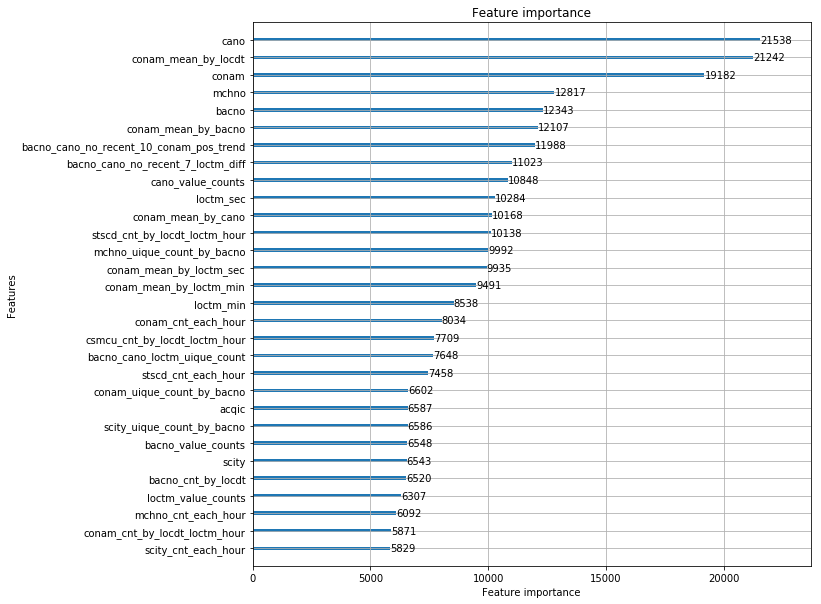

In [16]:
print('Plotting feature importances...')
plt.rcParams['figure.figsize'] = (10, 10)
ax = lgb.plot_importance(model_gbdt, 
                         # figsize=(36, 72), 
                         max_num_features=30)
plt.show()

### Save Feature Importance

In [15]:
booster = model_gbdt.booster_
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()
feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance})
feature_importance
feature_importance.to_csv('importance_model_pre_27_v2_cat_encode.csv',index=False)
feature_importance.sort_values("importance")

,feature_name,importance
41,sleep_time_conam_lower_3000,8
40,sleep_time,19
38,prime_time_normal,43
50,conam_mean_by_iterm,45
42,prime_time_fraud_conam_lower_3000,165
10,iterm,224
48,conam_mean_by_contp,241
39,prime_time_fraud,243
8,flbmk,267
56,conam_mean_by_stscd,319


### Delete less important features

In [ ]:
feature_importance = pd.read_csv('importance_model_pre_13_add_18_imp_ftrs.csv', index_col=None)
less_important_features = feature_importance.sort_values("importance")
less_important_features = less_important_features[less_important_features["importance"] < 500]['feature_name'].values.tolist()
less_important_features

In [17]:
imp_ftrs = ~X_train.columns.isin(less_important_features)
imp_ftrs

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False, False, False, False,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True,  True,  True, False, False,  True])

In [18]:
print_callback = lgb.print_evaluation(period=500)

result = model_gbdt.fit(X_train.loc[:, imp_ftrs], y_train, 
              eval_set=[(X_val.loc[:, imp_ftrs], y_val)],
              eval_metric='auc',
              # categorical_feature=categorical_feature_idx,
              early_stopping_rounds=100,
              verbose=0,
              callbacks=[print_callback]
             )

[500]	valid_0's binary_logloss: 0.0267076	valid_0's auc: 0.986897
[1000]	valid_0's binary_logloss: 0.0227996	valid_0's auc: 0.989614
[1500]	valid_0's binary_logloss: 0.0209376	valid_0's auc: 0.990947
[2000]	valid_0's binary_logloss: 0.019866	valid_0's auc: 0.991658
[2500]	valid_0's binary_logloss: 0.0191663	valid_0's auc: 0.992096
[3000]	valid_0's binary_logloss: 0.0186506	valid_0's auc: 0.99241
[3500]	valid_0's binary_logloss: 0.0182583	valid_0's auc: 0.992618
[4000]	valid_0's binary_logloss: 0.0179256	valid_0's auc: 0.992762
[4500]	valid_0's binary_logloss: 0.017624	valid_0's auc: 0.992896
[5000]	valid_0's binary_logloss: 0.0173916	valid_0's auc: 0.992977
[5500]	valid_0's binary_logloss: 0.0171781	valid_0's auc: 0.993062
[6000]	valid_0's binary_logloss: 0.016994	valid_0's auc: 0.993113
[6500]	valid_0's binary_logloss: 0.0168249	valid_0's auc: 0.993172
[7000]	valid_0's binary_logloss: 0.0166736	valid_0's auc: 0.993213
[7500]	valid_0's binary_logloss: 0.0165306	valid_0's auc: 0.993263


In [ ]:
## F1-score
# pred = model_gbdt.predict(X_train)
pred = model_gbdt.predict(X_train.loc[:, imp_ftrs])
# label=1的precision, recall, f1-score
precision_recall_fscore_support(y_train, pred, pos_label=1, average='binary')
# recall代表真的盜刷 -> 也預測到有盜刷
# precision代表預測有盜刷 -> 真的有盜刷

### Predict
TODO: 可試試看改thresholding

In [13]:
# test_pred = model_gbdt.predict(X_test.loc[:, imp_ftrs])
test_pred = model_gbdt.predict(X_test)
test_pred.sum()
# model_gbdt = joblib.load("pre_14_no_bacno_cano.pkl")
# ans = model_gbdt.predict(X_test)
# ans.sum()

4869

In [14]:
submission = pd.concat([test_raw["txkey"], pd.Series(test_pred, name='fraud_ind')], axis=1)
submission.to_csv("submission_63_pre_27_v2_cat_encode.csv", index=None)